In [ ]:
%matplotlib inline

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
import numpy as np
np.random.seed(0)
import torch.utils.data as data_utils #maybe do this to clean up

#Samples from: https://github.com/EliSchwartz/imagenet-sample-images
'''
citation:
Eli Schwartz, imagenet-sample-images, (2019), GitHub repository, https://github.com/EliSchwartz/imagenet-sample-images 
'''
n_epochs = 5
batch_size_train = 16
batch_size_test = 16
num_epochs = 200

learning_rate = 0.001
momentum = 0.9
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

preprocessing = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    torchvision.transforms.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

indices = torch.arange(20)

dataset = torchvision.datasets.ImageFolder(root= "/content/drive/MyDrive/Colab Notebooks/Project/", transform=preprocessing)

dataset = torch.utils.data.Subset(dataset, indices)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
dataset_labeled = []
i=0
for data, target in dataset:
  dataset_labeled.append((data, i))
  i+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


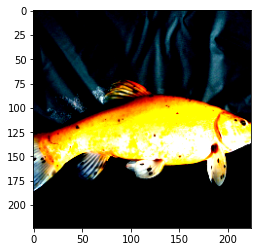

1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


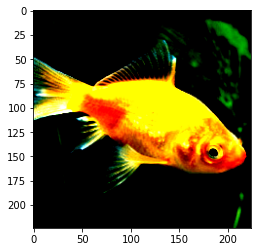

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


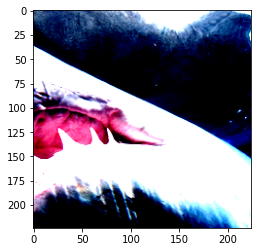

3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


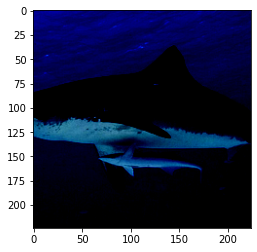

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


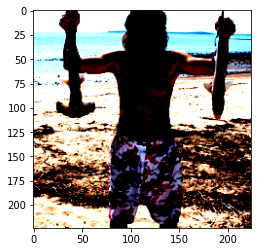

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5


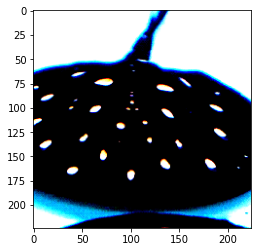

6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


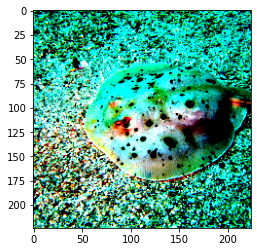

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7


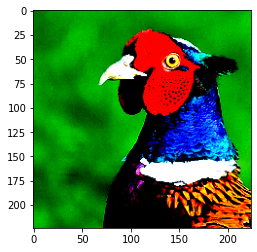

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


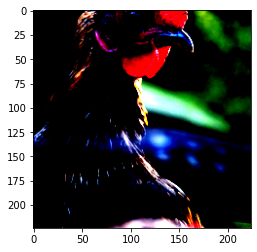

9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


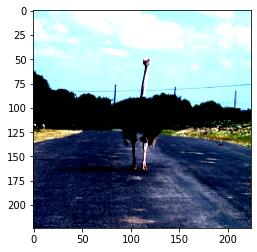

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10


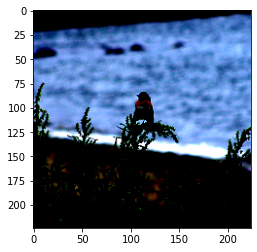

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11


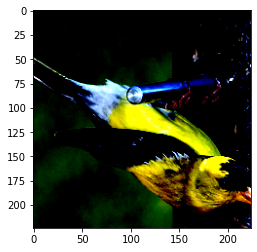

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12


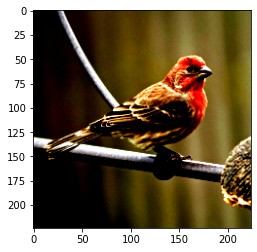

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13


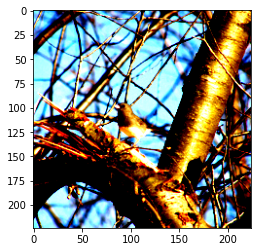

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14


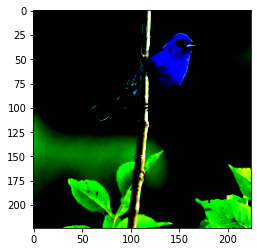

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15


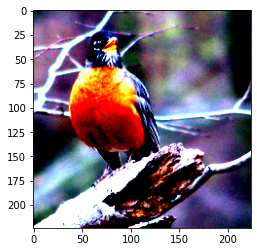

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16


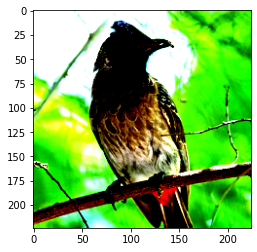

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17


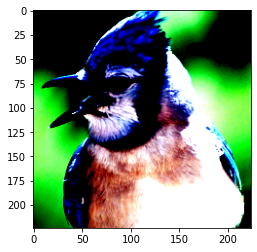

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18


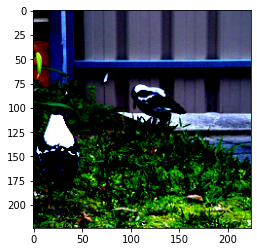

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19


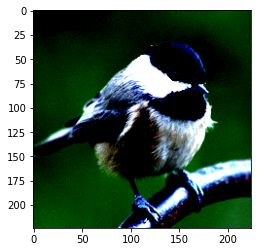

In [ ]:
for image, label in dataset_labeled:
  print(label)
  plt.imshow(image.permute(1,2,0))
  plt.show()


# Spearman rank correlation code

In [ ]:
def spearman_rank_corr(a, b):
    lin_a = a.reshape(-1)#convert iage to linear array for easier processing
    indices_a = lin_a.argsort()
    rank_a = torch.zeros_like(indices_a)
    rank_a[indices_a] = torch.arange(len(lin_a))

    lin_b = b.reshape(-1)
    indices_b = lin_b.argsort()
    rank_b = torch.zeros_like(indices_b)
    rank_b[indices_b] = torch.arange(len(lin_b))

    N = lin_a.size(0)
    num = torch.sum((rank_a - rank_b).pow(2))
    den = N*(N**2-1.0)#need to write like this for numerics, n^3 somestimes caused issues
    return 1.0 - ((6*num)/den)

# SmoothGrad code

In [ ]:
def calcImageGrad(image, model):
  model.eval()
  image.requires_grad_()
  output = model(image)
  class_ind = output.argmax()
  #print(class_ind)
  grad = output[0, class_ind]
  #print(grad)
  grad.backward()
  return torch.max(image.grad.data.abs(), dim=1)[0]

  
def smoothGrad(stdev, n, input, model):
  grad_stdev = float((stdev/100)*(torch.max(input[0])-torch.min(input[0])))
  #print("standard dev: ", grad_stdev)
  total =  torch.from_numpy(np.zeros(input.shape))
  image_tensor = input

  for i in range(n):
    #print_progress(i,n)
    size = input.shape
    input_image = (image_tensor.detach() + np.random.normal(0,grad_stdev, size = size)).float()
    input_image.requires_grad_()
    image_grad = calcImageGrad(input_image, model)
    #print(image_grad.shape)
    #print(total.shape)
    total = total+image_grad
  return (total/n)

# Insert the weight rand code


In [ ]:
import torch
import torchvision
from torchvision import models
from torchvision import transforms
from torch import nn
import cv2
import numpy as np
import os
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from PIL import Image
import random

if not os.path.isfile("ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "ilsvrc2012_wordnet_lemmas.txt")
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

In [ ]:
def gradCAM(img, model, guided=False, cnn_layer_idx=None, class_idx=None, transform=None, save_heatmap=None, print_cls=False, print_pred=False):
    '''
    PARAMETERS
      img           : image for which grad-CAM will be plotted
      model         : model for which grad-CAM will be plotted
      cnn_layer_idx : (int) grad-CAM will be plotted with the result of this i-th 
                      convolutional layer of the model
      class_idx     : (int) idx of the class for which grad-CAM will be plotted
                      If None, the default predicted class will be used. 
    '''

    output = img

    cnn_i, sequential_i = 0, 0
    cnn_weights = []
    for module_i, module in enumerate(list(model.modules())[1:]):    
      if isinstance(module, torch.nn.modules.container.Sequential):
        continue
      else:       
        try:
          output = module(output)
          if isinstance(module, torch.nn.modules.pooling.AdaptiveAvgPool2d) :
            output = torch.flatten(output, 1)
        except Exception as e:
          print(module_i, module)
        if isinstance(module, torch.nn.modules.conv.Conv2d):
          cnn_weights.append(output)

    ### Step 1 ###
    # gradient of class c score (BEFORE softmax), wrt CNN feature map activations "layer weights"
    if class_idx is None:
      class_idx = torch.argmax(output, dim=-1).item()
    if print_cls:
      print("class:({})".format(class_idx), imagenet_labels[class_idx])
    #predicted
    cls_idx = torch.argmax(output, dim=-1)  
    if print_pred:
      print("predicted class:({})".format(cls_idx.item()), imagenet_labels[cls_idx.item()])
    grads = torch.autograd.grad(output[0, class_idx], cnn_weights[-1], retain_graph=True)
    grads = grads[0].squeeze(0)  # [n_filtermap, W_lastCNN, H_lastCNN]
    if guided:
      # Target for backprop
      one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
      one_hot_output[0][class_idx] = 1
      grads_guided = torch.autograd.grad(one_hot_output, img, retain_graph=True)
      grads_guided = grads_guided[0].squeeze(0)
      # Backward pass
      #output.backward(gradient=one_hot_output)
      # Convert Pytorch variable to numpy array
      # [0] to get rid of the first channel (1,3,224,224)
      #gradients_as_arr = self.gradients.data.numpy()[0]
      grads_guided = torch.clamp(grads_guided, min=0.).detach().numpy()

    ### Step 2 ###
    grads_avgpooled = torch.mean(grads, axis=(1,2))  # [n_filtermap] 
    grads_avgpooled = grads_avgpooled.expand_as(cnn_weights[-1].squeeze(0).permute(1,2,0))
    grads_avgpooled = grads_avgpooled.permute(2,0,1)

    ### Step 3 : ReLU of Linear Combination ###
    
    map = nn.ReLU()(grads_avgpooled*cnn_weights[-1].squeeze(0))   # layer_weights shape
    map = torch.sum(map, dim=0)  # [W_lastCNN, H_lastCNN]
    map_interpolated = np.array(cv2.resize(map.detach().numpy(), dsize=img.shape[2:], interpolation=cv2.INTER_CUBIC))

    if guided:
      guided_map = map_interpolated*grads_guided
      plt.imshow(guided_map.transpose(1,2,0))
      plt.show()

    ### Step 4 ###
    map_interpolated = cv2.resize(map.detach().numpy(), dsize=img.shape[2:], interpolation=cv2.INTER_CUBIC)
    # make color heatmap
    heatmap = cv2.normalize(map_interpolated, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # overlay heatmap on top of the image
    fin = heatmap

    return class_idx, fin[:,:,::-1]

In [ ]:
model = models.alexnet(pretrained=True)
model.eval()
for data, label in dataset_labeled:
  data = data.unsqueeze(0)
  output = model(data)
  output_max_index = output.argmax()

  print(output_max_index, label)

tensor(0) 0
tensor(1) 1
tensor(2) 2
tensor(3) 3
tensor(842) 4
tensor(5) 5
tensor(6) 6
tensor(86) 7
tensor(8) 8
tensor(9) 9
tensor(10) 10
tensor(11) 11
tensor(12) 12
tensor(91) 13
tensor(14) 14
tensor(15) 15
tensor(16) 16
tensor(17) 17
tensor(18) 18
tensor(19) 19


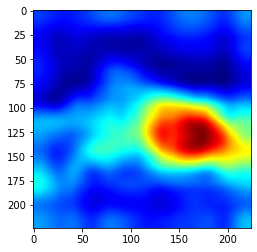

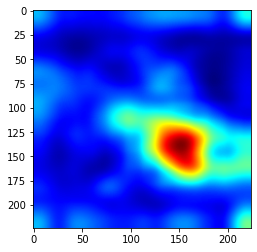

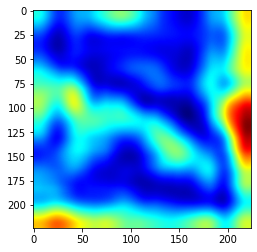

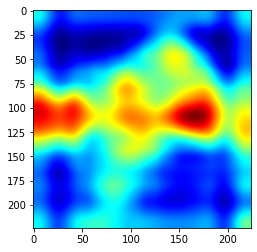

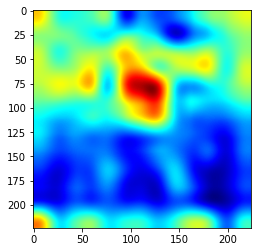

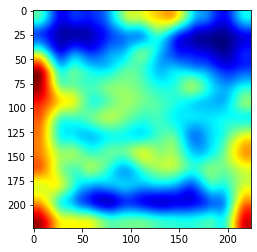

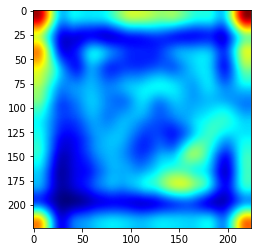

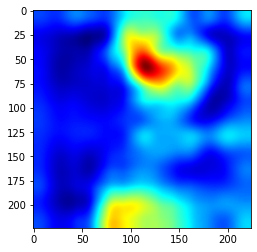

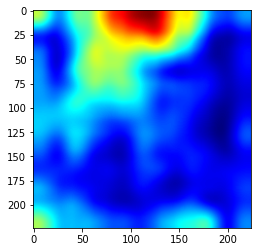

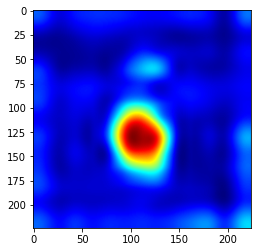

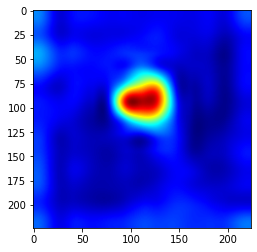

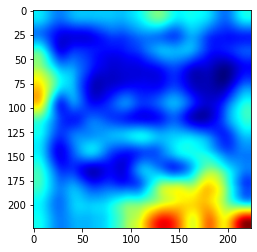

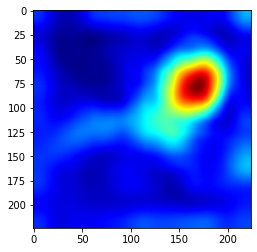

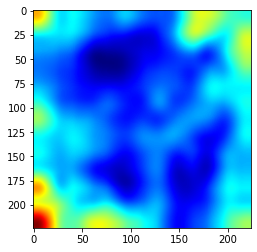

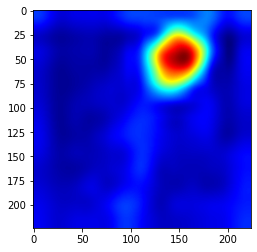

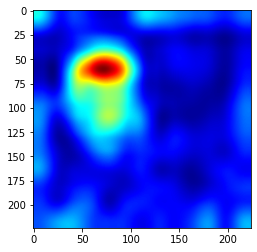

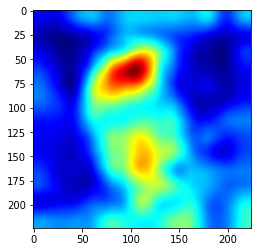

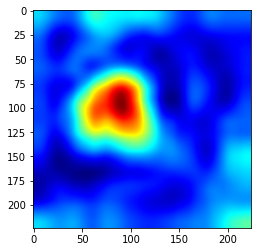

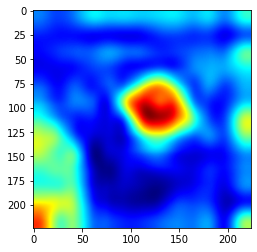

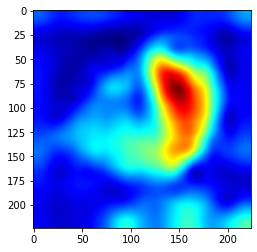

In [ ]:
for data, label in dataset_labeled:
  data = data.unsqueeze(0)
  data = data.to("cpu")
  _, h = gradCAM(data, model, class_idx=label)
  plt.imshow(h)
  plt.show()
  
  #this is just a check loop
  

In [ ]:
cdef cascading_randomization(model, img_path, class_idx, transform=None, guided=False):

  predicted_cls, heatmap = gradCAM(img_path, model, class_idx=class_idx)
  saliency =  smoothGrad(20, 20, img_path, model)

  w_dict = model.state_dict()
  heatmaps = [heatmap]
  saliencies = [saliency]

  n_weight_randomizations = 0
  layer_names = ["original"]
  for key_i, key in enumerate(list(model.state_dict().keys())[::-1]):
    np.random.seed(999)
    w_dict[key] = torch.tensor(np.random.normal(0, 0.01, w_dict[key].shape)) # randomize current layer weights
    model.load_state_dict(w_dict)
    if key[-6:] == "weight":
      predicted_cls, heatmap = gradCAM(img_path, model, guided=guided, class_idx=class_idx, transform=transform, print_cls=False)
      saliency =  smoothGrad(20, 20, img_path, model)

      heatmaps.append(heatmap)
      saliencies.append(saliency)
      layer_names.append(key)
      n_weight_randomizations += 1
  return heatmaps, saliencies


In [ ]:
def spearman_hs_calcs(h,s):
  spearman_gradCAM = [float(1)]
  spearman_smoothgrad = [float(1)]
  for i in range(len(h)-1):
    heatmap_true = h[0]
    heatmap_random = h[i+1]
    heatmap_true = torch.from_numpy(np.flip(heatmap_true,axis=0).copy())
    heatmap_random = torch.from_numpy(np.flip(heatmap_random,axis=0).copy())
    spearman_gradCAM = np.append(spearman_gradCAM,spearman_rank_corr(heatmap_true,  heatmap_random))
  for i in range(len(s)-1):
    saliency_true = s[0]
    saliency_random = s[i+1]
    spearman_smoothgrad = np.append(spearman_smoothgrad,spearman_rank_corr(saliency_true.squeeze(0)[0],  saliency_random.squeeze(0)[0]))
  return (spearman_gradCAM, spearman_smoothgrad)    

In [ ]:

spearman_gradCAM_total = [np.ones(9)]
spearman_smoothgrad_total = [np.ones(9)]

for data, label in dataset_labeled:
  print("image: ", label)
  data = data.unsqueeze(0)
  data = data.to("cpu")
  h,s = cascading_randomization(models.alexnet(pretrained = True), data, label, transform=None, guided=False)
  spearman_h, spearman_s = spearman_hs_calcs(h,s)
  print( spearman_h)
  print( spearman_s)
  spearman_gradCAM_total = np.append(spearman_gradCAM_total, [spearman_h], axis = 0)
  spearman_smoothgrad_total = np.append(spearman_smoothgrad_total, [spearman_s], axis = 0)


  

image:  0
[ 1.          0.90126228  0.79513657  0.89214939  0.36323464  0.10075283
  0.01543009  0.05456448 -0.17050779]
[1.         0.87792146 0.88487846 0.8300792  0.47254217 0.44526911
 0.66647261 0.62156928 0.55860472]
image:  1
[ 1.          0.7580356   0.85207719  0.77439737  0.68001783  0.53546989
 -0.22770941 -0.20362055 -0.24780488]
[1.         0.86551428 0.87731886 0.8261503  0.6082682  0.53747445
 0.70681018 0.6620816  0.65887976]
image:  2
[ 1.00000000e+00  6.71027899e-01  5.70642948e-01  6.50060773e-01
  3.94570410e-01  3.16855669e-01 -2.12192535e-05 -8.93003941e-02
 -9.15254354e-02]
[1.         0.79782045 0.72227943 0.69069344 0.32186168 0.14506578
 0.37469727 0.32650149 0.29868531]
image:  3
[ 1.          0.70149928  0.65014195  0.77874196  0.68749309  0.20819688
  0.26146114  0.20360905 -0.22063529]
[1.         0.64870495 0.6026538  0.58563584 0.26120621 0.25887513
 0.30348438 0.32000977 0.35028493]
image:  4
[ 1.          0.55794024  0.45333153  0.44523042  0.42385805 

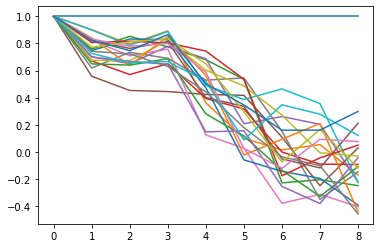

In [ ]:
for i in spearman_gradCAM_total:
  plt.plot(i)

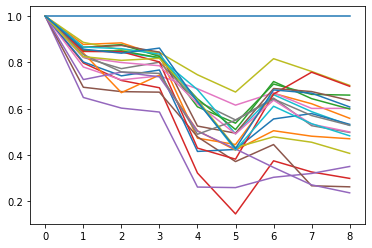

In [ ]:
for i in spearman_smoothgrad_total:
  plt.plot(i)

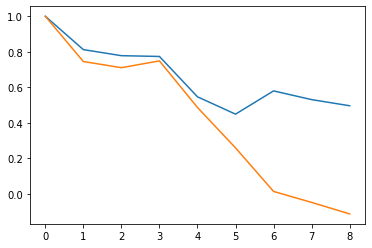

In [ ]:
spearman_smoothgrad_total = spearman_smoothgrad_total[1:]
spearman_gradCAM_total = spearman_gradCAM_total[1:]
spearman_smoothgrad_avg = np.mean(spearman_smoothgrad_total, axis = 0)
spearman_gradCAM_avg = np.mean(spearman_gradCAM_total, axis = 0)
plt.plot(spearman_smoothgrad_avg)
plt.plot(spearman_gradCAM_avg)

In [ ]:
max_gradCAM = np.max(spearman_gradCAM_total, axis  =0)
min_gradCAM = np.min(spearman_gradCAM_total, axis  =0)
max_smoothgrad = np.max(spearman_smoothgrad_total, axis  =0)
min_smoothgrad = np.min(spearman_smoothgrad_total, axis  =0)

In [ ]:
model = models.alexnet(pretrained=True)
w_dict = model.state_dict()
n_weight_randomizations = 0
layer_names = ["original"]
for key_i, key in enumerate(list(model.state_dict().keys())[::-1]):
  model.load_state_dict(w_dict)
  if key[-6:] == "weight":
    layer_names.append(key)
    n_weight_randomizations += 1

In [ ]:
for i in range(len(layer_names)):
  layer_names[i] = str(layer_names[i])

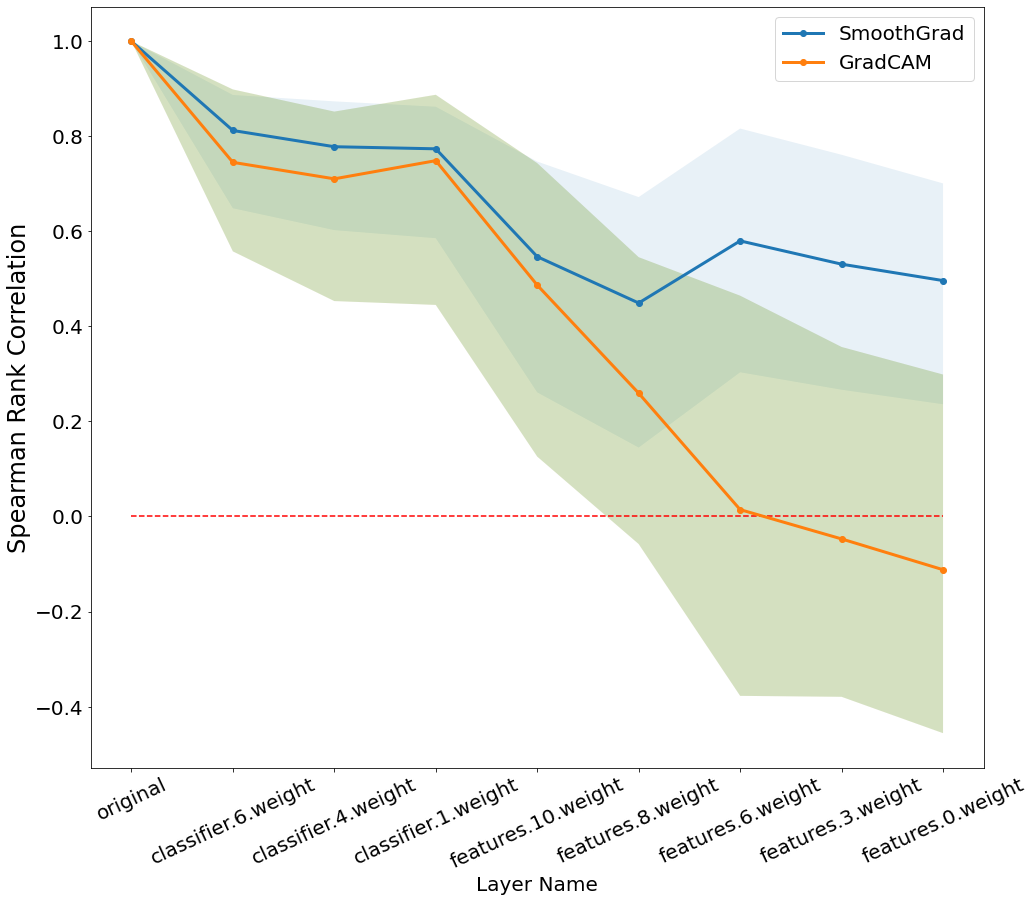

In [ ]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
f, ax = plt.subplots(figsize=(16.0, 14.0))
xaxis = [0,1,2,3,4,5,6,7,8]

ax.plot(xaxis, spearman_smoothgrad_avg, "o-", linewidth=3, color = 'C0')
ax.fill_between(xaxis, min_smoothgrad, max_smoothgrad, alpha=0.1)

ax.plot(xaxis, spearman_gradCAM_avg,"o-", linewidth=3, color='C1')
ax.fill_between(xaxis, min_gradCAM, max_gradCAM, alpha=0.1)

ax.set_xticks(xaxis)
ax.set_xticklabels(layer_names)
plt.xticks(rotation=25)
ax.legend(["SmoothGrad", "GradCAM"],  prop={'size':20})
ax.set_ylabel("Spearman Rank Correlation", fontsize=24)
ax.set_xlabel("Layer Name", fontsize=20)
ax.hlines(0, 0,8, colors="r", linestyles="dashed")
ax.fill_between(xaxis, min_gradCAM, max_gradCAM, alpha=0.2)
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Project/output_images/cascading_random_alexnet.jpg")

#Spare copy of data


image:  0
[ 1.          0.90126228  0.79513657  0.89214939  0.36323464  0.10075283
  0.01543009  0.05456448 -0.17050779]
[1.         0.87792146 0.88487846 0.8300792  0.47254217 0.44526911
 0.66647261 0.62156928 0.55860472]
image:  1
[ 1.          0.7580356   0.85207719  0.77439737  0.68001783  0.53546989
 -0.22770941 -0.20362055 -0.24780488]
[1.         0.86551428 0.87731886 0.8261503  0.6082682  0.53747445
 0.70681018 0.6620816  0.65887976]
image:  2
[ 1.00000000e+00  6.71027899e-01  5.70642948e-01  6.50060773e-01
  3.94570410e-01  3.16855669e-01 -2.12192535e-05 -8.93003941e-02
 -9.15254354e-02]
[1.         0.79782045 0.72227943 0.69069344 0.32186168 0.14506578
 0.37469727 0.32650149 0.29868531]
image:  3
[ 1.          0.70149928  0.65014195  0.77874196  0.68749309  0.20819688
  0.26146114  0.20360905 -0.22063529]
[1.         0.64870495 0.6026538  0.58563584 0.26120621 0.25887513
 0.30348438 0.32000977 0.35028493]
image:  4
[ 1.          0.55794024  0.45333153  0.44523042  0.42385805  0.41738755
  0.10980463 -0.24833977  0.03004813]
[1.         0.69289684 0.67399669 0.67166364 0.4784357  0.37147814
 0.44505894 0.2667641  0.26220793]
image:  5
[ 1.          0.8237018   0.7087189   0.75745648  0.12602097  0.02823031
 -0.37752569 -0.31144142 -0.40349829]
[1.         0.7805894  0.72498947 0.74177802 0.6865598  0.61550689
 0.66886675 0.60139406 0.60159427]
image:  6
[ 1.          0.61828411  0.7345627   0.69010091  0.52935529  0.545645
  0.15311444 -0.34825766 -0.14685261]
[1.         0.82220966 0.77341378 0.80121291 0.6318875  0.55150408
 0.64601278 0.52671838 0.49745327]
image:  7
[ 1.          0.67565739  0.6729086   0.82044357  0.60289878  0.4864316
  0.27248234 -0.00559103 -0.03006923]
[1.         0.88703775 0.8550477  0.8432169  0.74691534 0.67217153
 0.81635785 0.76120669 0.70094621]
image:  8
[ 1.          0.89871877  0.78590286  0.88746864  0.49189162  0.38664156
  0.46467245  0.3567335  -0.22350287]
[1.         0.85377872 0.84512889 0.81991488 0.68265158 0.4915759
 0.66070843 0.58736193 0.52847862]
image:  9
[ 1.          0.74695897  0.83240223  0.82765853  0.47314209 -0.05802643
 -0.14242196 -0.19418907 -0.39141238]
[1.         0.80240619 0.74223244 0.76746851 0.41535532 0.42394751
 0.55574036 0.57894927 0.53251058]
image:  10
[ 1.          0.83973718  0.63685781  0.85131919  0.56445718 -0.02261305
  0.09403968  0.20994598 -0.44082952]
[1.         0.84106517 0.66958278 0.74545598 0.50460285 0.42109764
 0.50492167 0.48117959 0.47003859]
image:  11
[ 1.          0.64911664  0.64019233  0.6871587   0.28115326  0.11831087
 -0.13454878 -0.32756448 -0.10680842]
[1.         0.85009104 0.85028601 0.82051647 0.64287722 0.50998342
 0.71764553 0.64363253 0.59906656]
image:  12
[ 1.          0.80641407  0.81627023  0.80291522  0.74358952  0.53595495
 -0.17472136 -0.04322517  0.05036443]
[1.         0.84773123 0.84656864 0.80229187 0.42967945 0.38189602
 0.66333032 0.75796252 0.69701475]
image:  13
[ 1.          0.69976455  0.66675675  0.64659083  0.14796746  0.15683901
 -0.25329161 -0.37950957 -0.04207563]
[1.         0.72608328 0.7587316  0.73790169 0.50334007 0.42595911
 0.34611028 0.27077866 0.2361716 ]
image:  14
[ 1.          0.81952411  0.76314867  0.81272894  0.40095532  0.33608639
 -0.05068195 -0.11723292  0.21188539]
[1.         0.86522841 0.87359214 0.8447569  0.52510273 0.49422503
 0.68747354 0.67420888 0.6360023 ]
image:  15
[ 1.          0.83259767  0.77894956  0.80027145  0.58692384  0.02633476
 -0.12028182  0.09413415  0.07703876]
[1.         0.82258773 0.79988074 0.78592509 0.62101173 0.49093014
 0.63696826 0.53307188 0.49963129]
image:  16
[ 1.          0.74149054  0.72242504  0.63009691  0.44342983  0.1797322
 -0.03496444 -0.10052693 -0.45603585]
[1.         0.83416462 0.75923872 0.75272882 0.48950136 0.54976869
 0.64198804 0.5704717  0.52824855]
image:  17
[ 1.          0.77102256  0.8111217   0.83417267  0.65032595  0.2960785
 -0.07324922  0.1666069  -0.118222  ]
[1.         0.82521605 0.80918014 0.81806332 0.63810802 0.4320274
 0.47849518 0.45508921 0.40691215]
image:  18
[1.         0.72578406 0.65791929 0.66631651 0.52104688 0.08947086
 0.34754741 0.27873778 0.1223008 ]
[1.         0.86670119 0.85981655 0.83604038 0.6327967  0.42171961
 0.61065662 0.53532046 0.48290157]
image:  19
[1.         0.82322174 0.74657488 0.86474359 0.50236541 0.346084
 0.16055274 0.16129422 0.29871678]
[1.         0.85756755 0.84015709 0.86230183 0.62997198 0.42820162
 0.68128252 0.66739571 0.6078195 ]